In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler,AutoencoderKL
import torch
from pytorch_lightning import seed_everything
from PIL import Image
from controlnet_aux import ZoeDetector


In [5]:
base_model_path = "/data/Realistic_Vision_V5.1_noVAE"
vae_model_path = "/data/sd-vae-ft-mse"
controlnet_path = "/home/liuxiaoyu/compare/controlnet/control_v11f1p_sd15_depth"
depth_path = '/home/liuxiaoyu/SmartControl'
smart_ckpt = "/home/liuxiaoyu/compare/controlnet/result/depth/220.ckpt"
negative_prompt_path = '/home/liuxiaoyu/compare/controlnet/realisticvision-negative-embedding'
device = "cuda"

load pretrain model

In [6]:
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)


vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet,vae=vae, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


extract depth

/home/liuxiaoyu/anaconda3/envs/smartcontrol/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


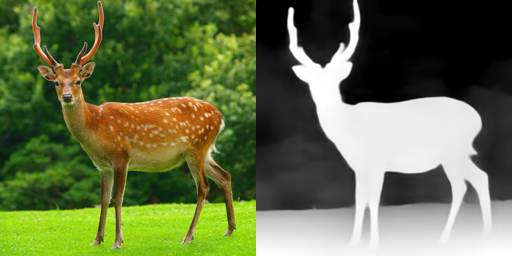

In [7]:

preprocessor = ZoeDetector.from_pretrained(depth_path)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


image = Image.open("assets/images/deer.png")
depth_map = preprocessor(image)
image_grid([image.resize((256, 256)), depth_map.resize((256, 256))], 1, 2)

Forward

Global seed set to 12345
100%|██████████| 50/50 [00:09<00:00,  5.43it/s]


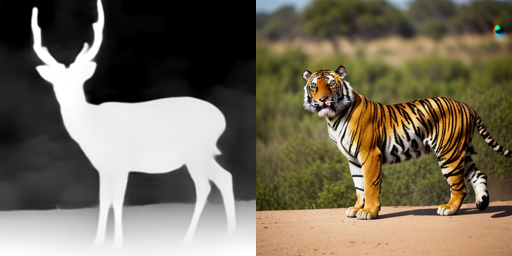

In [8]:

prompt = 'a tiger'

from smartcontrol import register_unet
pipe = register_unet(pipe,smart_ckpt)

seed_everything(12345)
output = pipe(
    prompt=prompt, 
    image=depth_map,
    negative_prompt=negative_prompt_path,
    controlnet_conditioning_scale = 1.0

).images[0]

image_grid([ depth_map.resize((256, 256)),output.resize((256,256))], 1, 2)
